***`Операционная статистика активности чата Peach Blossom в Telegram`***

## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import math
import datetime as dt
from calendar import monthrange
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
import plotly.graph_objects as go

import bamboolib as bam

# import parquet
import json
import pyarrow.feather as feather
import pyarrow

import time

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')


###############################################
# from plotly.plotly import iplot

import plotly.io as pio
png_renderer = pio.renderers["png"]
png_renderer.width = 1000
png_renderer.height = 1000
pio.renderers.default = "png"

# from nltk.stem import SnowballStemmer 
# russian_stemmer = SnowballStemmer('russian')
# from pymystem3 import Mystem 


# pd.set_option('display.max_rows', 200)

## Когортный анализ

### Загрузка, обработка, конвертация

In [2]:
# a = pd.read_json(r"N:\TG archives\Peach Blossom\result.json").replace('\\', '/')

# df = pd.json_normalize(a.messages, max_level=30)

# df = df.rename(columns={'date':'f_date'})


# Step: Keep rows where action is one of: invite_members
# df_inv = df.loc[df['action'].isin(['invite_members'])]

# Step: Select columns
# df_inv = df_inv[['f_date', 'actor_id', 'action']].reset_index()
# df_inv.to_feather('N:\TG archives\Peach Blossom\peach_blossom_inv.feather')

Когортный анализ будет проводиться для промежутка в месяц на интервале полгода

In [6]:
df_inv = pd.read_feather("N:\TG archives\Peach Blossom\peach_blossom_inv.feather")
df = pd.read_feather("N:\TG archives\Peach Blossom\peach_blossom.feather")

def user_id(col):
    if 'user' in (col):
        id_ = ''
        for i in col:
            if i.isdigit():
                id_ += i
        return id_
    else: return np.nan
df_inv['actor_id'] = df_inv.actor_id.apply(user_id)


import pandas as pd; import numpy as np
# Step: Change data type of actor_id to Integer
df_inv['actor_id'] = df_inv['actor_id'].astype('Int64')

import pandas as pd; import numpy as np
# Step: Keep rows where from_id is not missing
df = df.loc[df['from_id'].notna()]

df.from_id = df.from_id.apply(user_id)
import pandas as pd; import numpy as np
# Step: Change data type of from_id to Integer
df['from_id'] = df['from_id'].astype('Int64')

df = df.query('from_id.notna()')

In [7]:
in_list = list(df_inv.actor_id.unique())
# len(in_list)

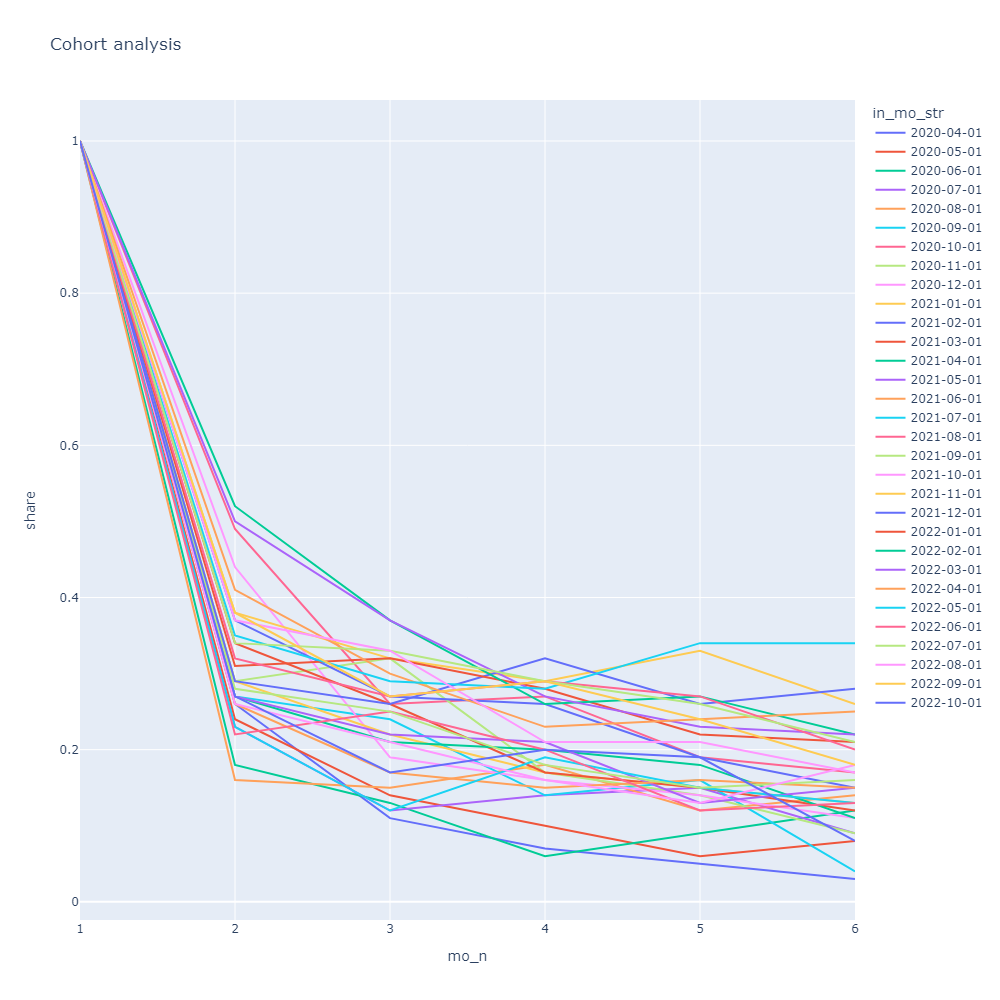

In [8]:
df = pd.read_feather("N:\TG archives\Peach Blossom\peach_blossom.feather")
df = df.loc[df['from_id'].notna()]
df.from_id = df.from_id.apply(user_id)
df['from_id'] = df['from_id'].astype('Int64')

df = df.query('from_id in @in_list', engine='python')
df['mo'] = df.f_date.astype('datetime64[M]')
df['in_mo'] = df.groupby('from_id').mo.transform('min')
df['coh_size'] = df.groupby('in_mo').from_id.transform('nunique')
df
df_res = df.groupby(['mo', 'in_mo', 'coh_size'], as_index=False)\
    .agg(nunq = ('from_id','nunique'), mes_cnt = ('from_id','count'))
df_res = df_res.sort_values(['in_mo', 'mo']).rename(columns={'nunq': 'coh_mo_cnt'})
df_res['share'] = (df_res.coh_mo_cnt / df_res.coh_size).round(2)
df_res['mo_n'] = df_res.groupby(['in_mo']).mo.rank(method='first').astype(int)
df_res['in_mo_str'] = df_res.in_mo.astype(str)
df_res['mo_cnt'] = df_res.groupby('in_mo').mo_n.transform('count')
df_res = df_res.query('mo_cnt > 5 and mo_n < 7')

import plotly.express as px
fig = px.line(df_res, x='mo_n', y='share', color='in_mo_str', title='Cohort analysis')
fig.write_html(f'N://Cohort analysis.html')
fig
# df_res

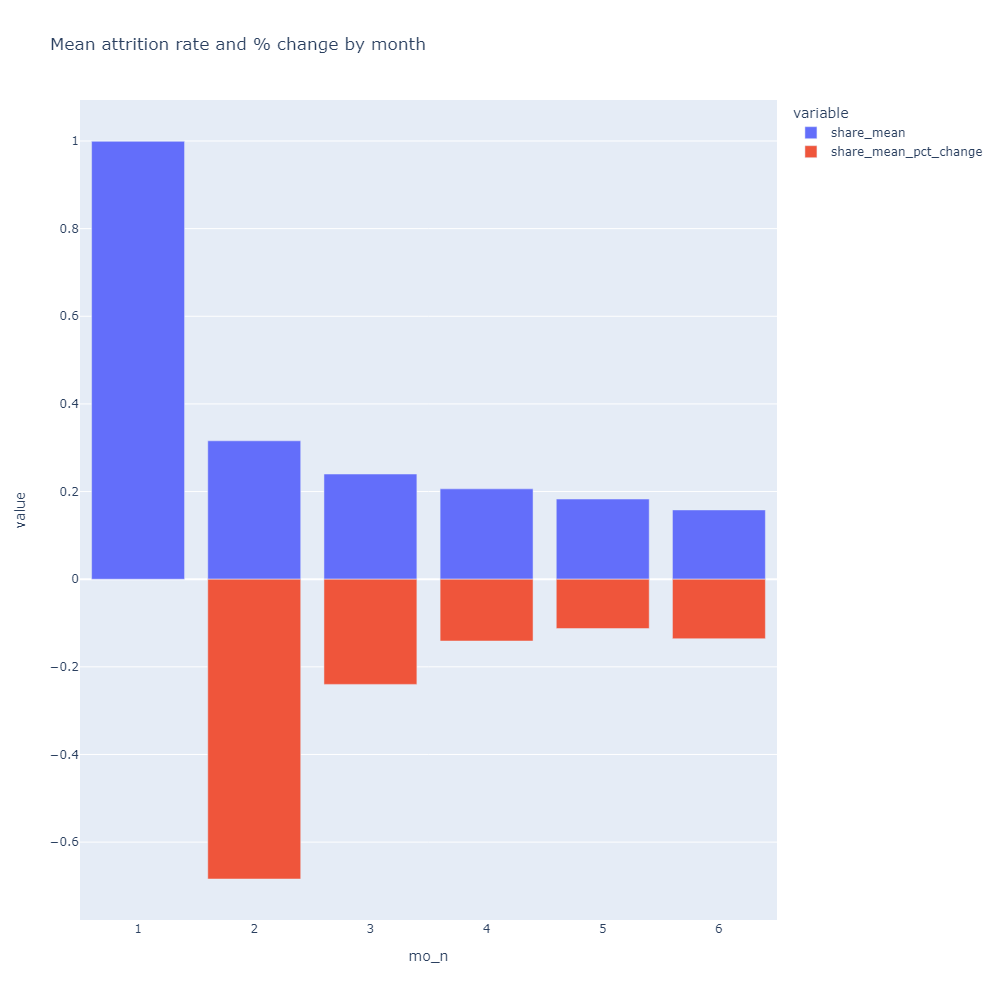

In [9]:
import pandas as pd; import numpy as np
# Step: Group by mo_n and calculate new column(s)
df_res_mean = df_res.groupby(['mo_n']).agg(share_mean=('share', 'mean')).reset_index()

import pandas as pd; import numpy as np
# Step: Percentage change
df_res_mean['share_mean_pct_change'] = df_res_mean['share_mean'].transform('pct_change')

df_res_mean = df_res_mean.fillna(0)
import plotly.express as px
fig = px.bar(df_res_mean, x='mo_n', y=['share_mean', 'share_mean_pct_change'], title='Mean attrition rate and % change by month')
fig

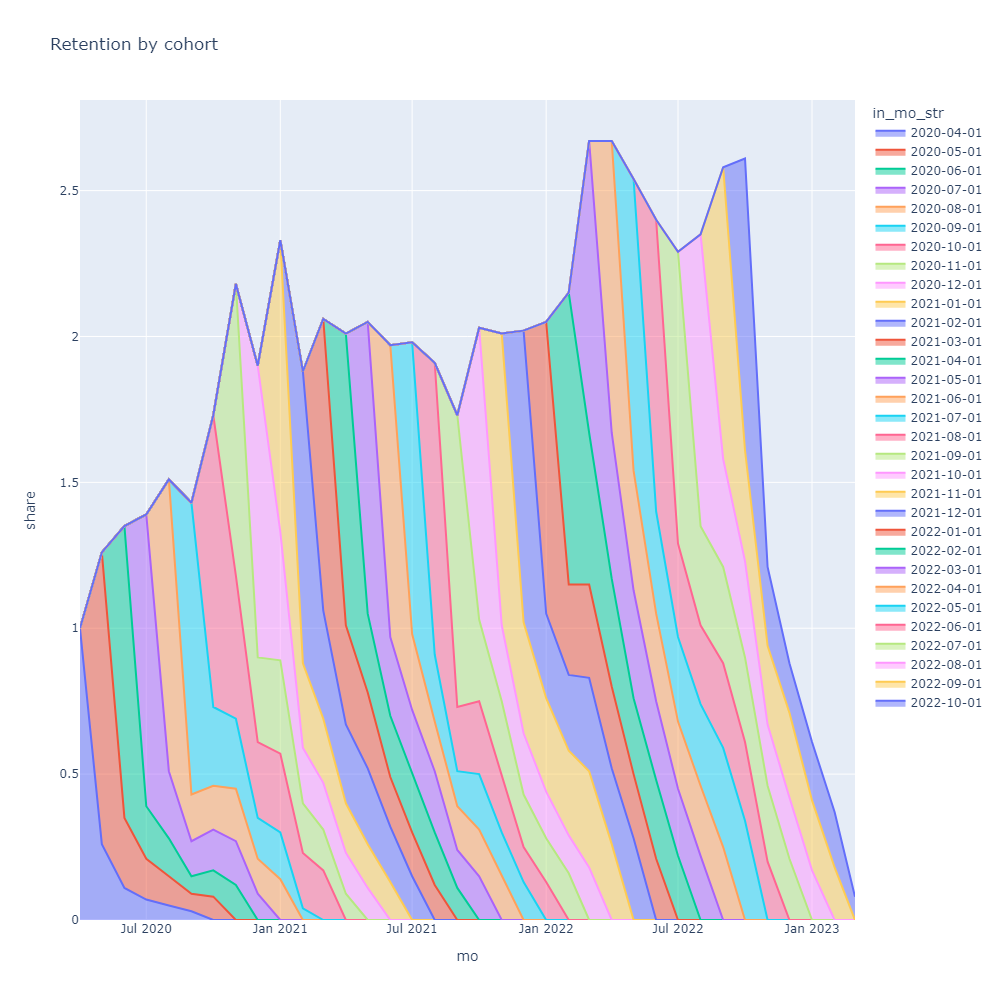

In [10]:
import plotly.express as px
fig = px.area(df_res, x='mo', y='share', color='in_mo_str', title='Retention by cohort')
fig

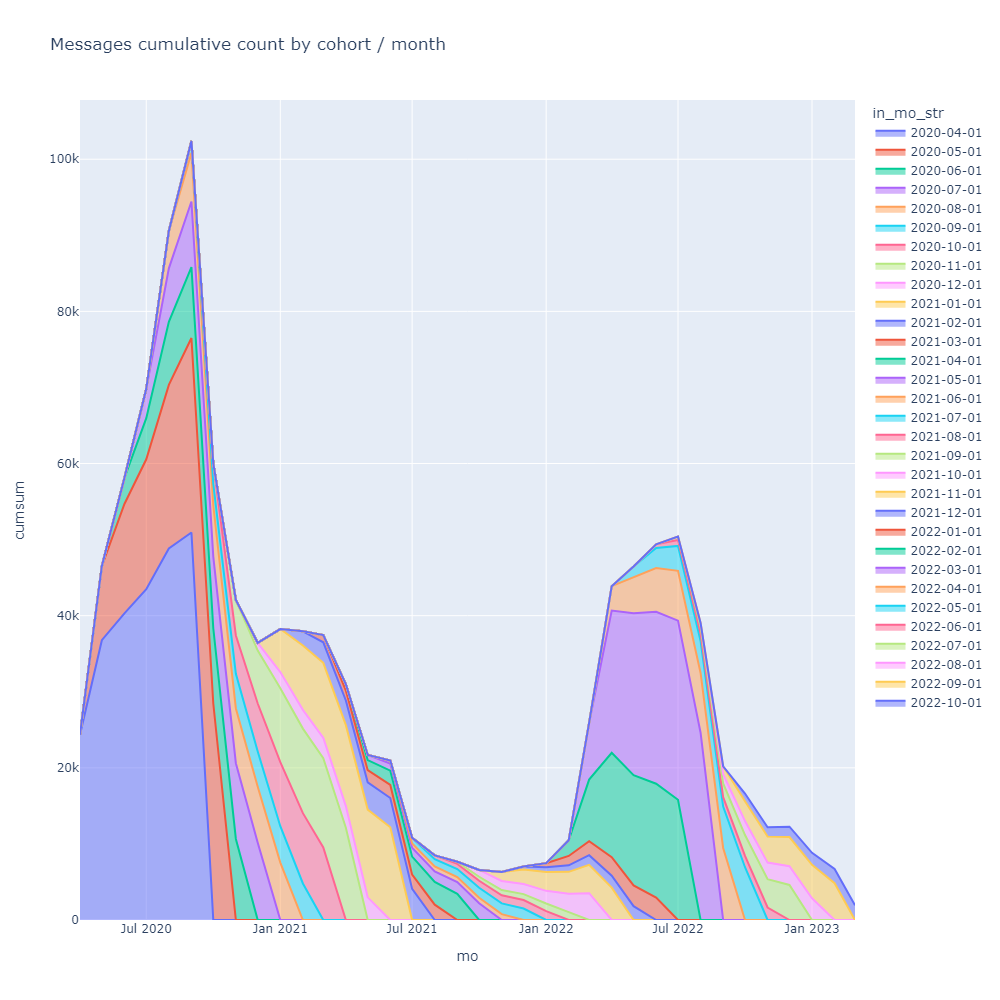

In [11]:
df_res['cumsum'] = df_res.groupby('in_mo').mes_cnt.transform('cumsum')
import plotly.express as px
fig = px.area(df_res, x='mo', y='cumsum', color='in_mo_str', title='Messages cumulative count by cohort / month')
fig

In [13]:
# df_res.coh_size.nunique()

### DAU, WAU, MAU, Sticky Factor

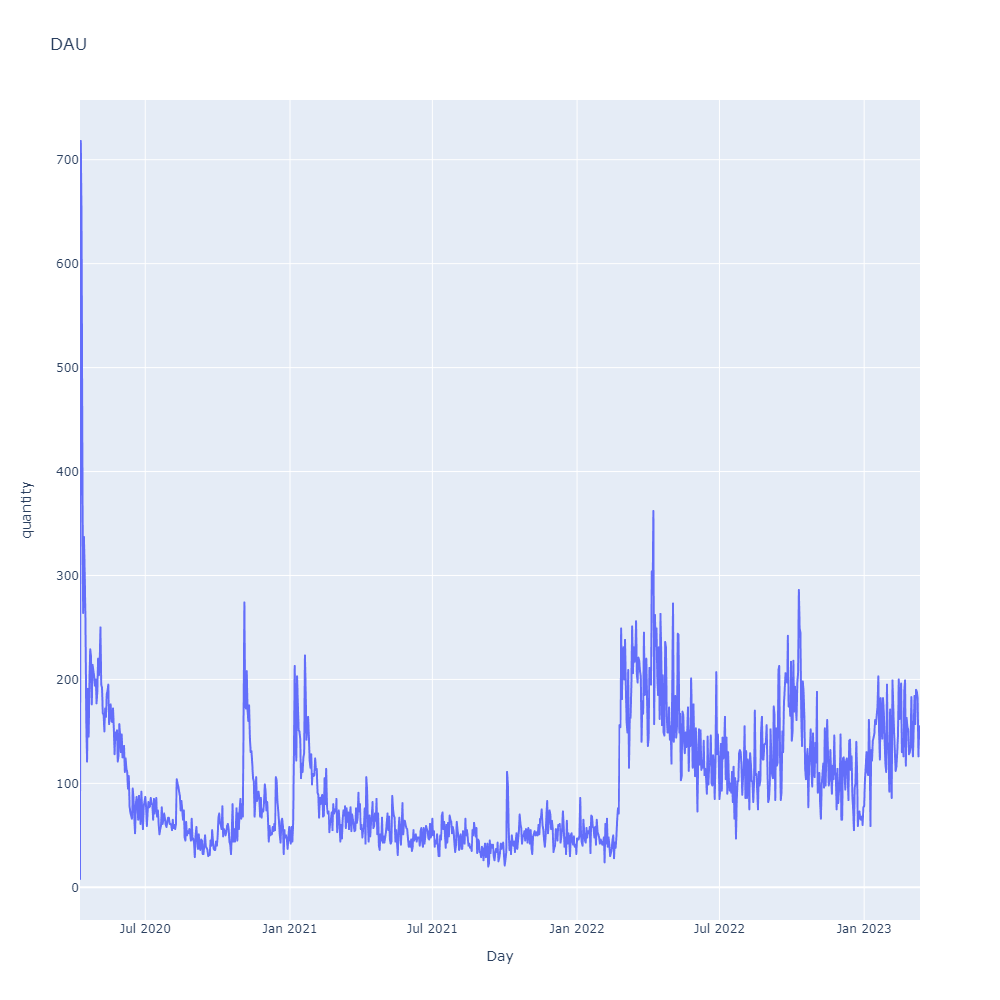

In [14]:
df['day'] = df.f_date.astype('datetime64[D]')
df['week'] = df.f_date.astype('datetime64[W]')
import pandas as pd; import numpy as np
# Step: Change datetime frequency
df_dau = df[['day', 'from_id']]
df_dau = df_dau.set_index('day').resample('1D').nunique().reset_index()

import plotly.express as px
fig = px.line(df_dau.sort_values(by=['day'], ascending=[True]), x='day', y='from_id', title='DAU')
fig.update_xaxes(title_text='Day')
fig.update_yaxes(title_text='quantity')
fig

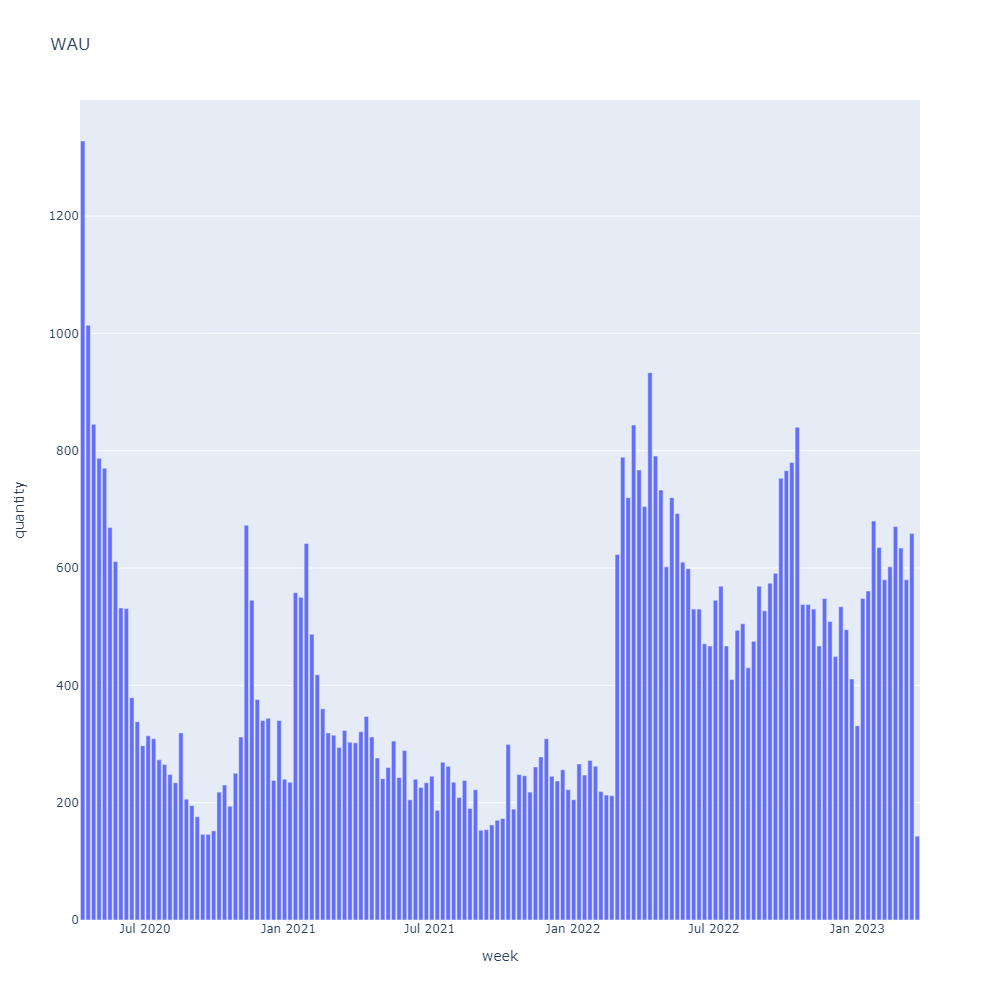

In [15]:
df_wau = df[['day', 'from_id']]
import pandas as pd; import numpy as np
# Step: Change datetime frequency
df_wau = df_wau.set_index('day').resample('1W').nunique().reset_index()

import plotly.express as px
fig = px.bar(df_wau.sort_values(by=['day'], ascending=[True]), x='day', y='from_id', title='WAU')
fig.update_xaxes(title_text='week')
fig.update_yaxes(title_text='quantity')
fig

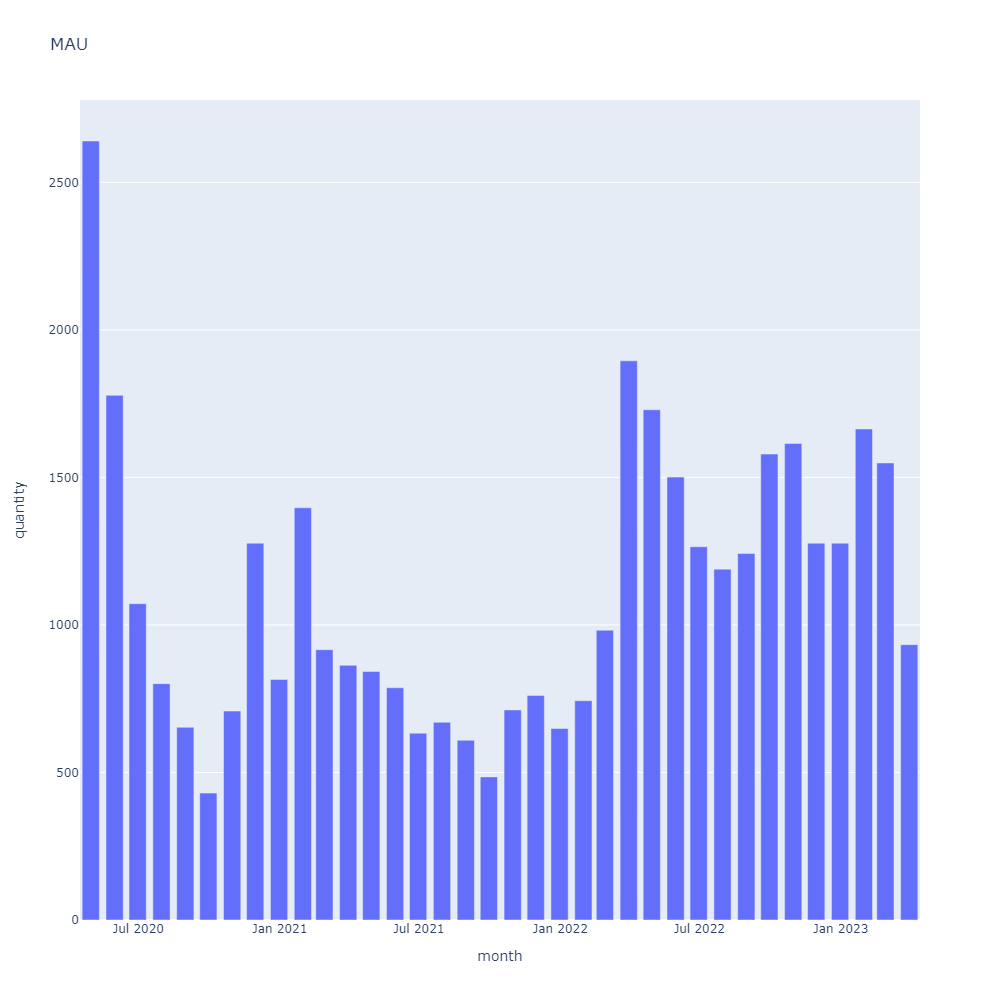

In [16]:
df_mau = df[['day', 'from_id']]
import pandas as pd; import numpy as np
# Step: Change datetime frequency
df_mau = df_mau.set_index('day').resample('1M').nunique().reset_index()

import plotly.express as px
fig = px.bar(df_mau.sort_values(by=['day'], ascending=[True]), x='day', y='from_id', title='MAU')
fig.update_xaxes(title_text='month')
fig.update_yaxes(title_text='quantity')
fig

#### Sticky Factor

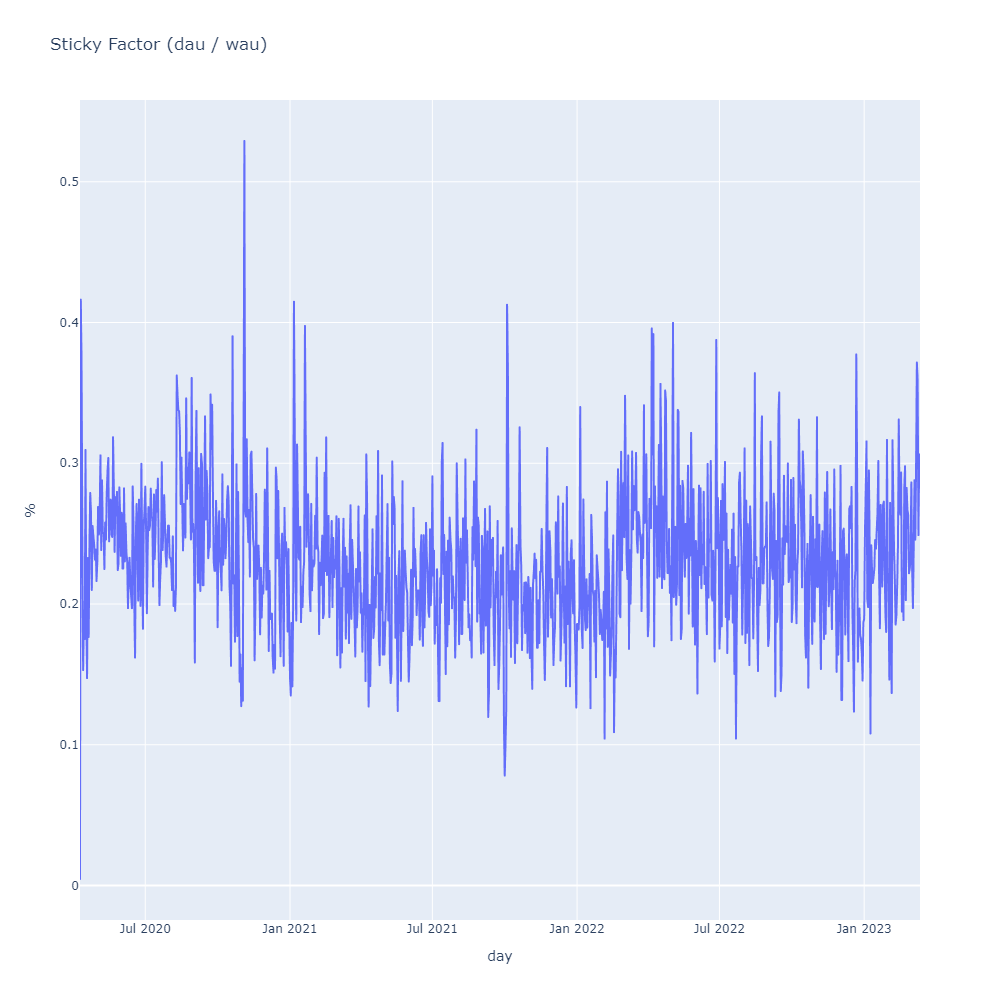

In [17]:
df_dwm = df[['day', 'from_id']]
df_dwm['week'] = df_dwm.day.astype('datetime64[W]')
df_dwm['mo'] = df_dwm.day.astype('datetime64[M]')
df_dwm['dau'] = df_dwm.groupby('day').from_id.transform('nunique')
df_dwm['wau'] = df_dwm.groupby('week').from_id.transform('nunique')
df_dwm['mau'] = df_dwm.groupby('mo').from_id.transform('nunique')
df_dwm['sf_dw'] = df_dwm.dau / df_dwm.wau
df_dwm['sf_dm'] = df_dwm.dau / df_dwm.mau
df_dwm['sf_wm'] = df_dwm.wau / df_dwm.mau
df_dw = df_dwm[['day', 'sf_dw']].drop_duplicates()

import plotly.express as px
fig = px.line(df_dw.sort_values(by=['day'], ascending=[True]), x='day', y='sf_dw', title='Sticky Factor (dau / wau)')
fig.update_yaxes(title_text='%')
fig

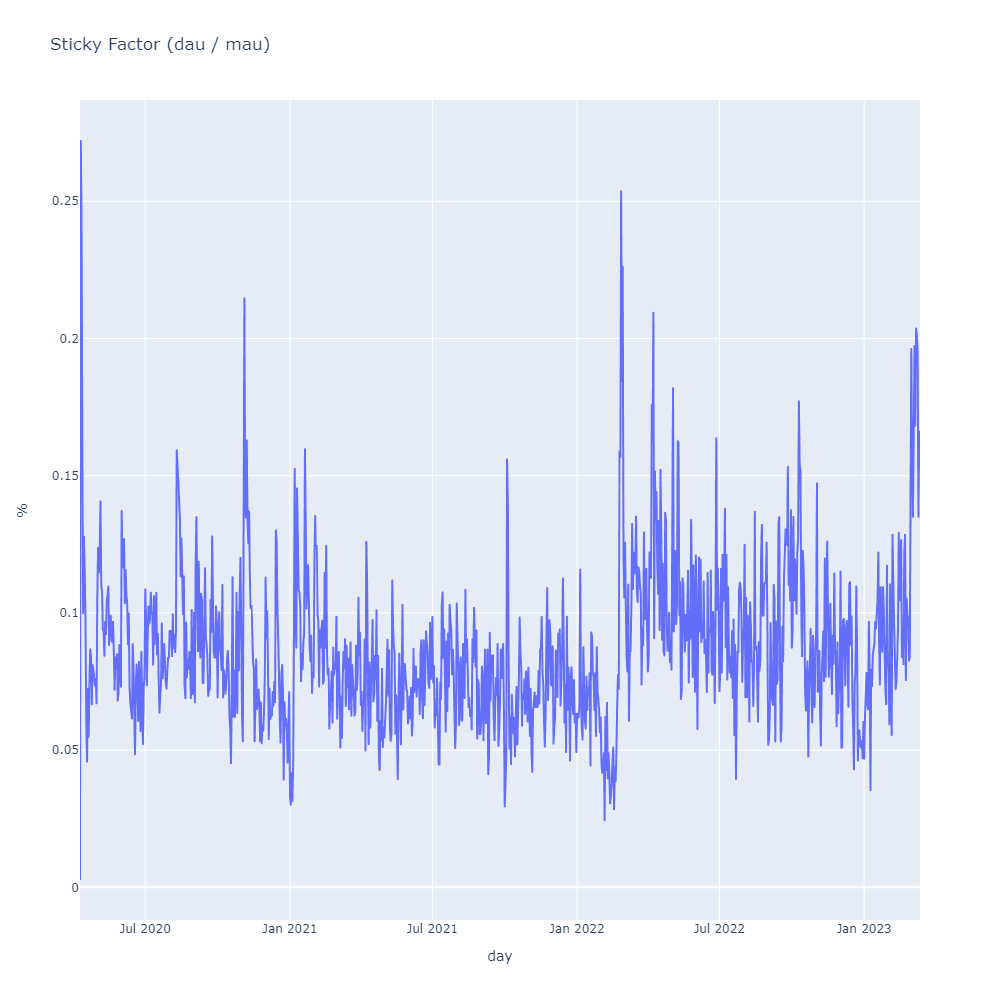

In [18]:
df_dm = df_dwm[['day', 'sf_dm']].drop_duplicates()

import plotly.express as px
fig = px.line(df_dm.sort_values(by=['day'], ascending=[True]), x='day', y='sf_dm', title='Sticky Factor (dau / mau)')
fig.update_yaxes(title_text='%')
fig

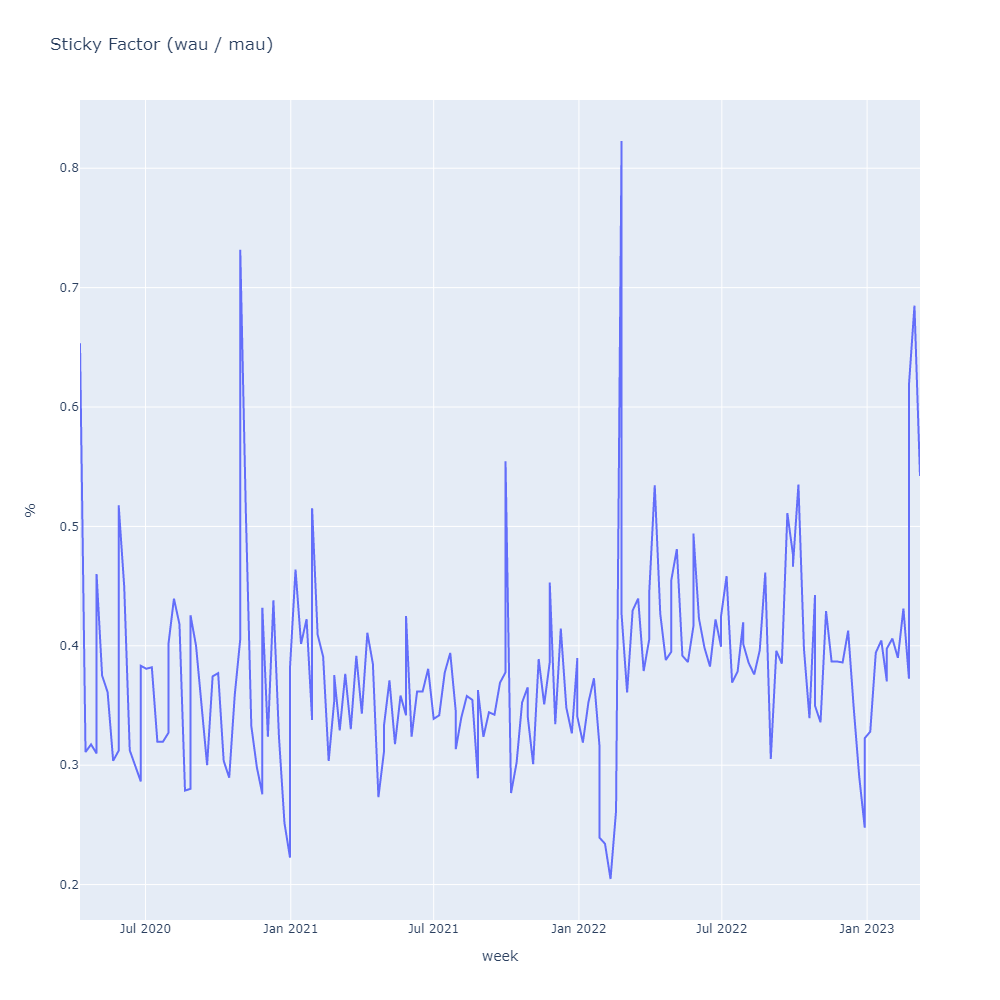

In [19]:
df_wm = df_dwm[['week', 'sf_wm']].drop_duplicates()

import plotly.express as px
fig = px.line(df_wm.sort_values(by=['week'], ascending=[True]), x='week', y='sf_wm', title='Sticky Factor (wau / mau)')
fig.update_yaxes(title_text='%')
fig

### **Вывод**

* Данные представлены с апреля 2020 года по март 2023 года
* Архив содержит 537,318 записей о совершенных действиях
* Кол-во приглашенных за отчетный период – 32,494
* Кол-во когорт – 31
* Период анализа когорт – 6 месяцев
* Средний уровень удержания на второй месяц оставляет 31,6%
* Все когорты имеют тенденцию снижения на второй месяц, некоторые - с небольшими всплесками уровня удержания порядка 2-5% в последующие месяцы
* Лучшая когорта с удержанием 52% на второй месяц стартовала в феврале 2022, худшая – с удержанием 16% - в августе 2020 года
* Имеются несколько когорт, наращивающие свое присутствие после второго месяца. Это: 2020-08, 2020-07, 2021-08, 2021-10, 2021-11, 2021-12, 2022-05, 2022-09, 2022-10
* Кумулятивный пик кол-ва сообщений когорт находится в сентябре 2020 и составляет порядка 102,000


## Количественный анализ

Пользователи несколько раз входили в группу и выходили из нее

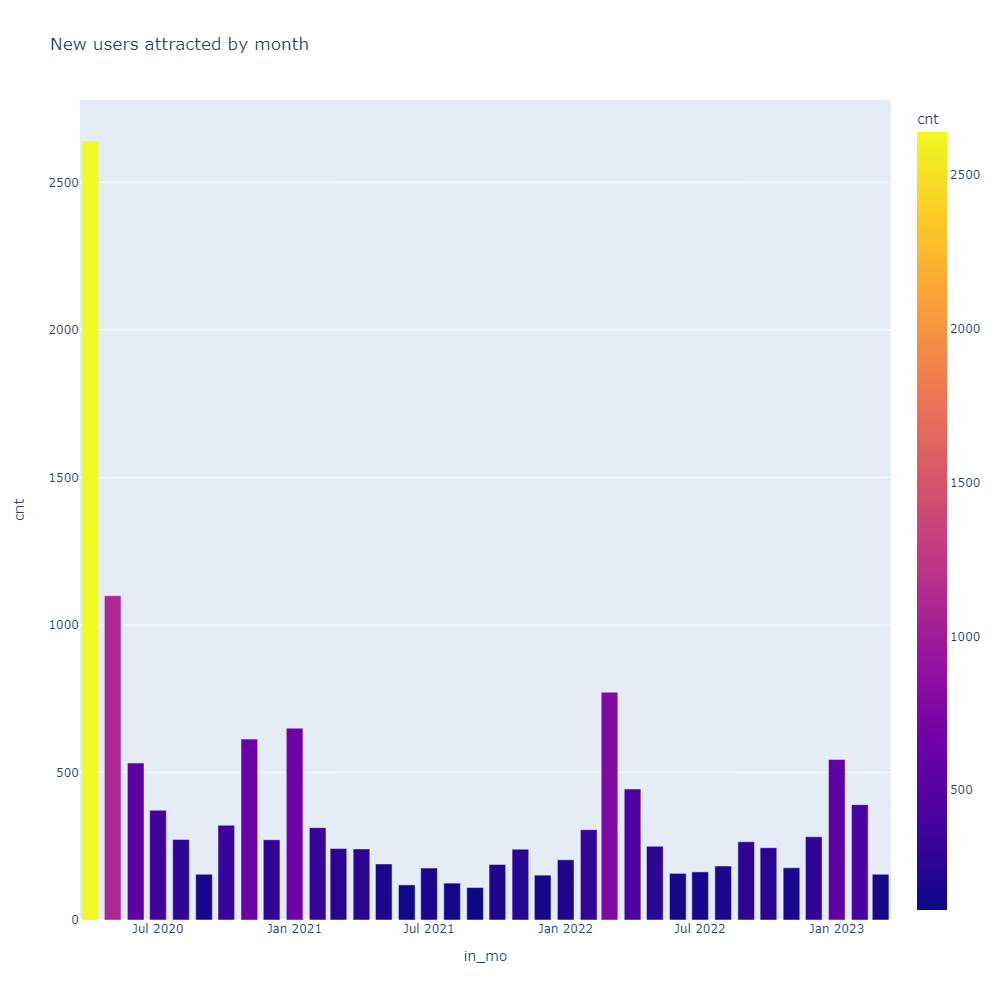

In [20]:
df_attr = df.query('from_id in @in_list', engine='python')
import pandas as pd; import numpy as np
# Step: Change data type of f_date to Datetime
df_attr['f_date'] = pd.to_datetime(df['f_date'], format='%Y-%m-%d %H:%M:%S')
df_attr['in_mo'] = df_attr.groupby('from_id').f_date.transform('min').astype('datetime64[M]')
df_attr_gr = df_attr.groupby('in_mo', as_index=False).from_id.nunique().rename(columns=({'from_id':'cnt'}))

import plotly.express as px
fig = px.bar(df_attr_gr, x='in_mo', y='cnt', color='cnt', title='New users attracted by month')
fig

In [22]:
# for i in df_attr_gr.agg(max_=('cnt', 'max'), min_=('cnt','min')).cnt:
#     display(df_attr_gr.query('cnt == @i'))
# round(df_attr_gr.cnt.mean(), 0)


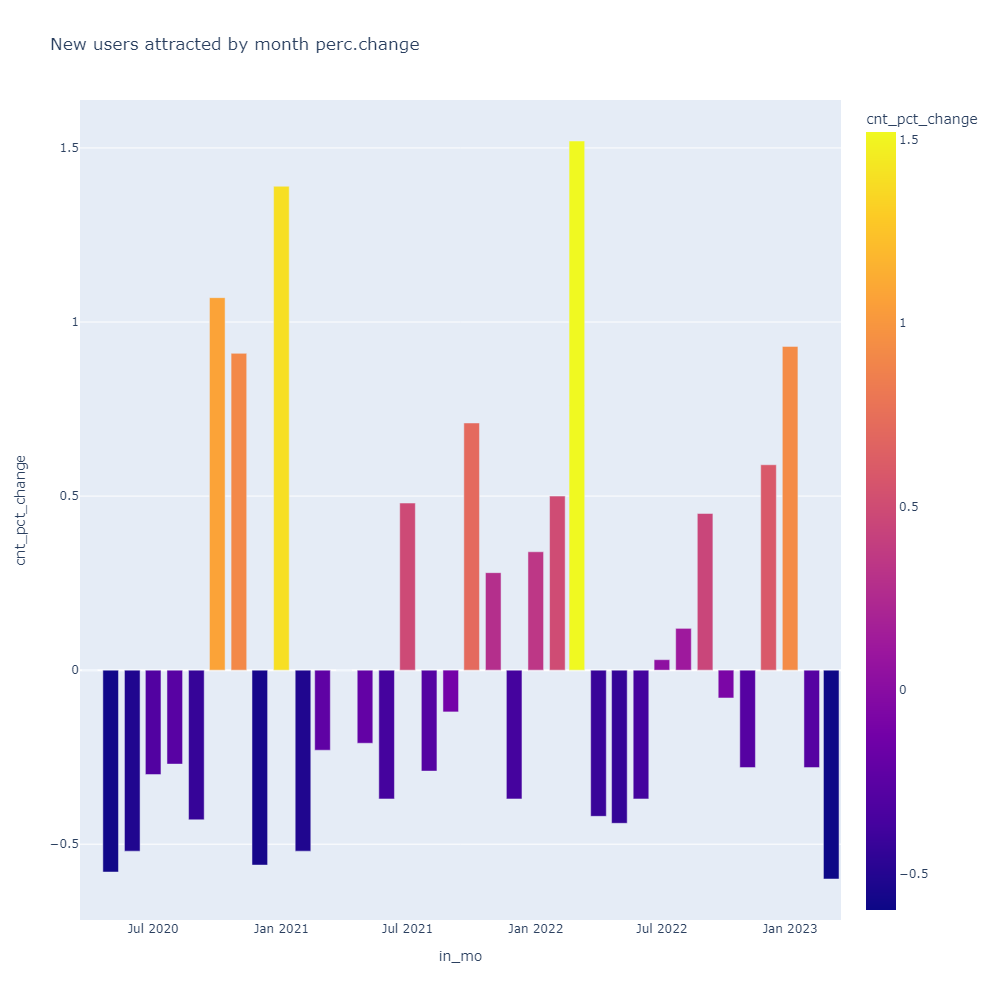

In [23]:
import pandas as pd; import numpy as np
# Step: Percentage change
df_attr_gr['cnt_pct_change'] = df_attr_gr['cnt'].transform('pct_change').round(2)
df_attr_gr = df_attr_gr.fillna(0)

import plotly.express as px
fig = px.bar(df_attr_gr, x='in_mo', y='cnt_pct_change', color='cnt_pct_change', title='New users attracted by month perc.change')
fig

In [24]:
# for i in df_attr_gr.agg(max_=('cnt_pct_change', 'max'), min_=('cnt_pct_change','min')).cnt_pct_change:
#     display(df_attr_gr.query('cnt_pct_change == @i'))
# round(df_attr_gr.cnt_pct_change.mean(), 0)

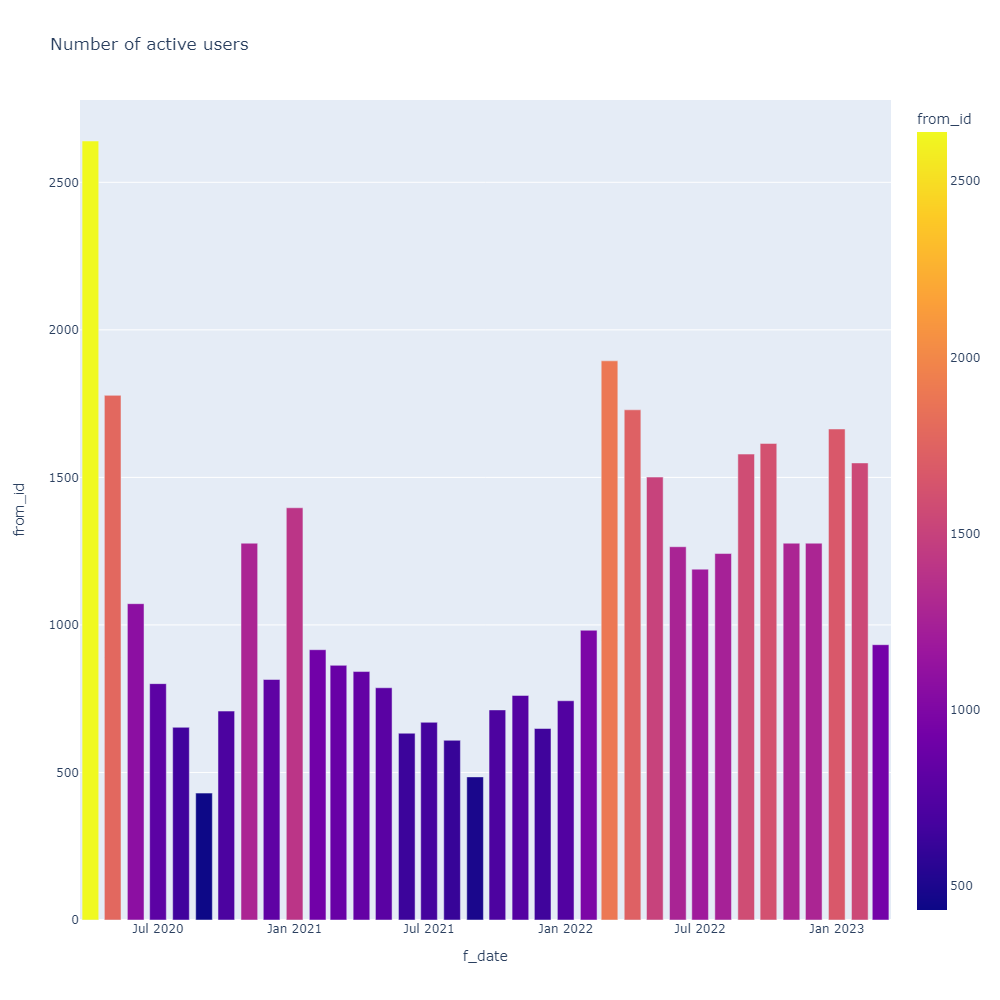

In [25]:
df_mo_unq = df[['f_date', 'from_id']]
import pandas as pd; import numpy as np
# Step: Change datetime frequency
df_mo_unq = df_mo_unq.set_index('f_date').resample('1MS').nunique().reset_index()

import plotly.express as px
fig = px.bar(df_mo_unq, x='f_date', y='from_id', color='from_id', title='Number of active users')
fig

In [26]:
# for i in df_mo_unq.agg(max_=('from_id', 'max'), min_=('from_id','min')).from_id:
#     display(df_mo_unq.query('from_id == @i'))
# round(df_mo_unq.from_id.mean(), 0)

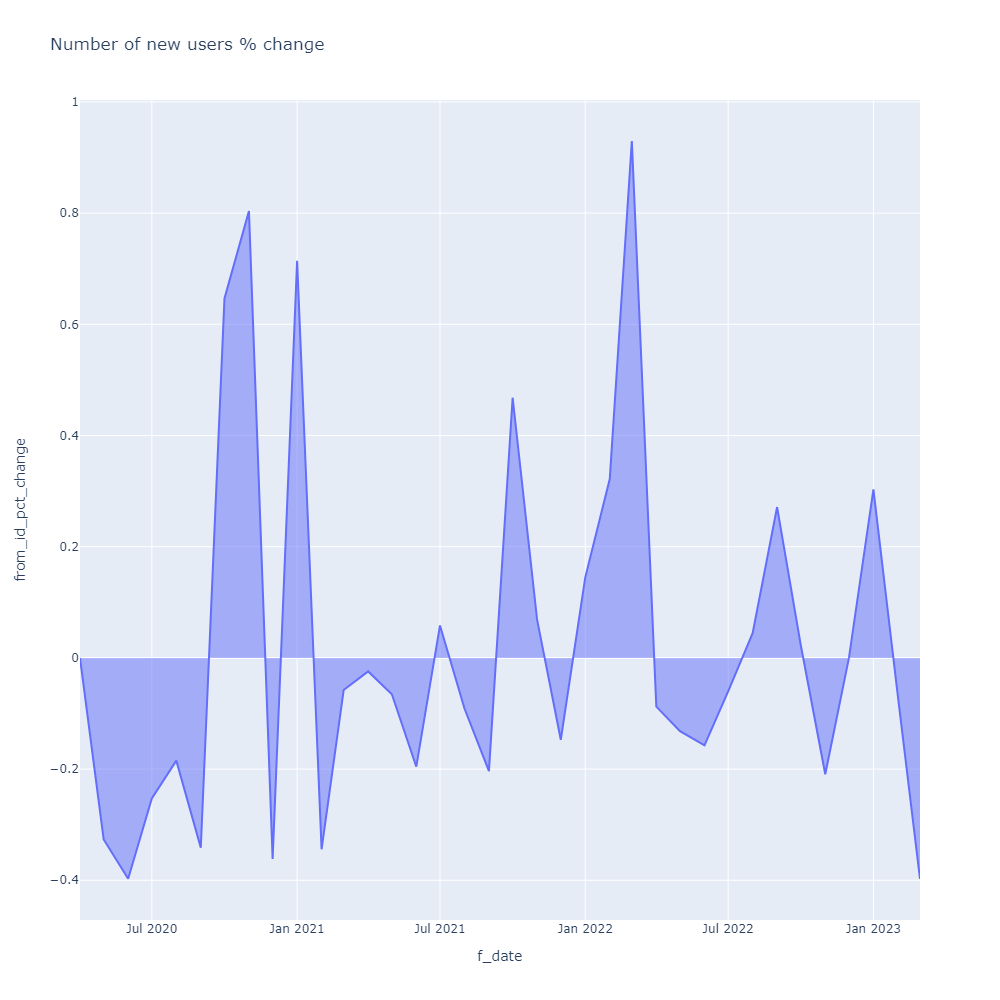

In [27]:
import pandas as pd; import numpy as np
# Step: Percentage change
df_mo_unq['from_id_pct_change'] = df_mo_unq['from_id'].transform('pct_change')

df_mo_unq = df_mo_unq.fillna(0)
import plotly.express as px
fig = px.area(df_mo_unq, x='f_date', y='from_id_pct_change', title='Number of new users % change')
fig

2020-04-09 23:38:30
2023-03-13 22:34:39
Unique names: 13562
Quantity of messages: 391841


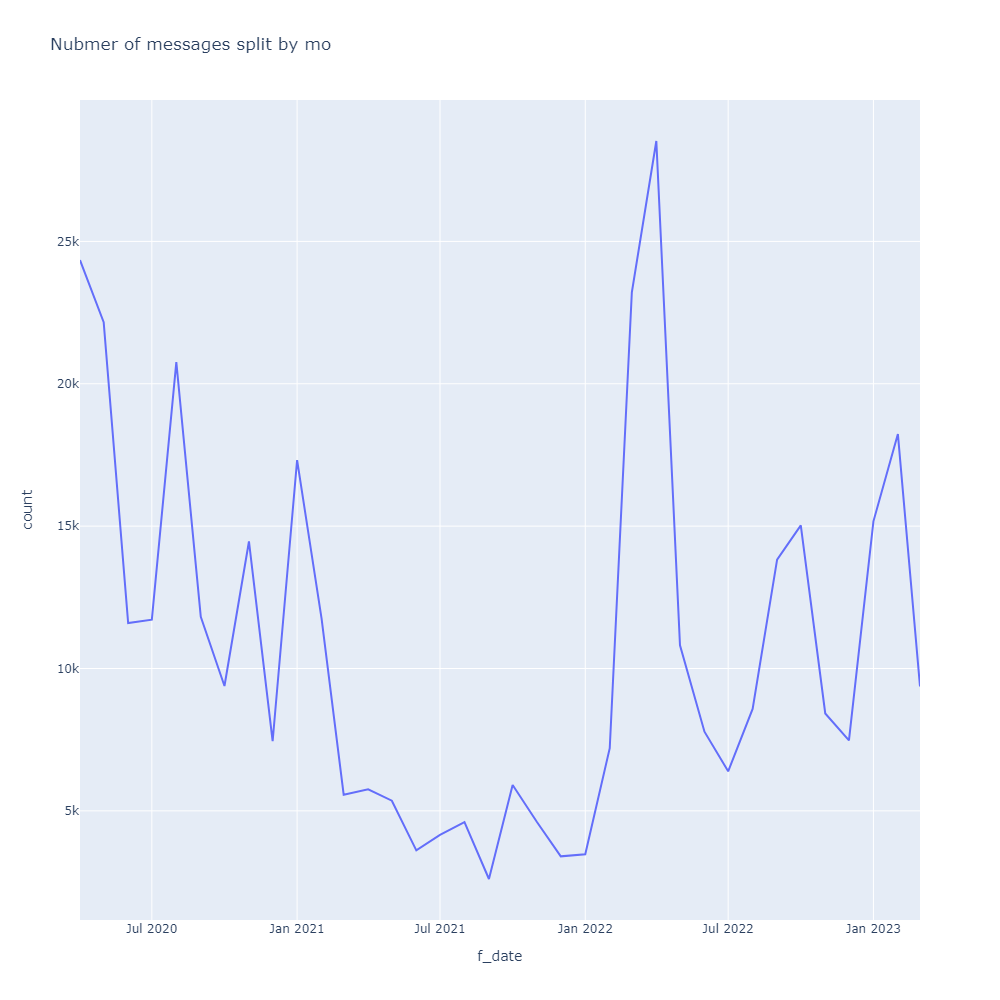

In [28]:
print(df.f_date.min())
print(df.f_date.max())
print('Unique names:', df.from_id.nunique())
print('Quantity of messages:', df.shape[0])
df['f_date'] = pd.to_datetime(df['f_date'], format='%Y-%m-%d %H:%M:%S')
import pandas as pd; import numpy as np
# Step: Change datetime frequency
df_mes_cnt = df.set_index('f_date').resample('1MS').size().to_frame(name='count').reset_index()

import plotly.express as px
fig = px.line(df_mes_cnt.sort_values(by=['f_date'], ascending=[True]), x='f_date', y='count'\
             , title='Nubmer of messages split by mo')
fig

In [29]:
# for i in df_mes_cnt.agg(max_=('count', 'max'), min_=('count','min'))['count']:
#     display(df_mes_cnt.query('count == @i'))
# round(df_mes_cnt['count'].mean(), 0)

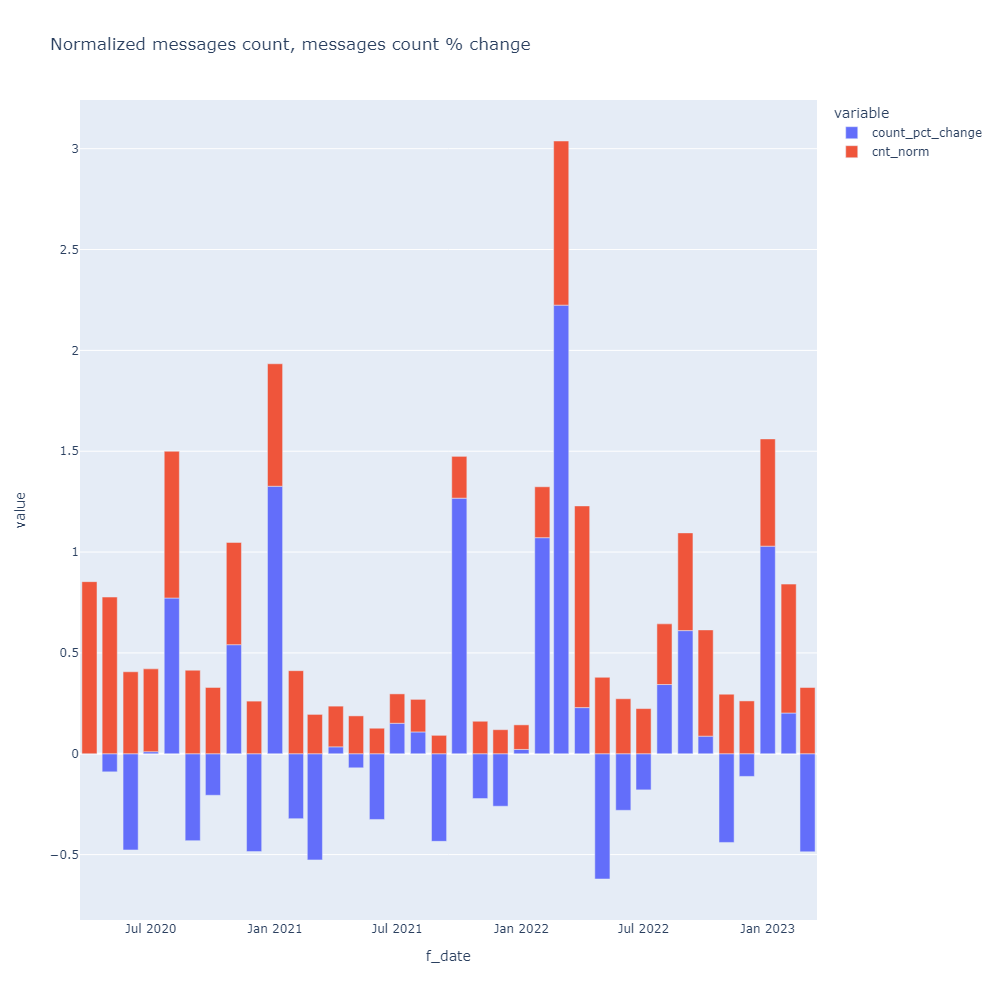

In [30]:
import pandas as pd; import numpy as np
# Step: Percentage change
df_mes_cnt['count_pct_change'] = df_mes_cnt['count'].transform('pct_change')

df_mes_cnt = df_mes_cnt.fillna(0)
df_mes_cnt['cnt_norm'] = df_mes_cnt['count'] / df_mes_cnt['count'].max()
import plotly.express as px
fig = px.bar(df_mes_cnt, x='f_date', y=['count_pct_change', 'cnt_norm'], title='Normalized messages count, messages count % change')
fig

In [31]:
# for i in df_mes_cnt.agg(max_=('count_pct_change', 'max'), min_=('count_pct_change','min'))['count_pct_change']:
#     display(df_mes_cnt.query('count_pct_change == @i'))
# round(df_mes_cnt['count_pct_change'].mean(), 0)

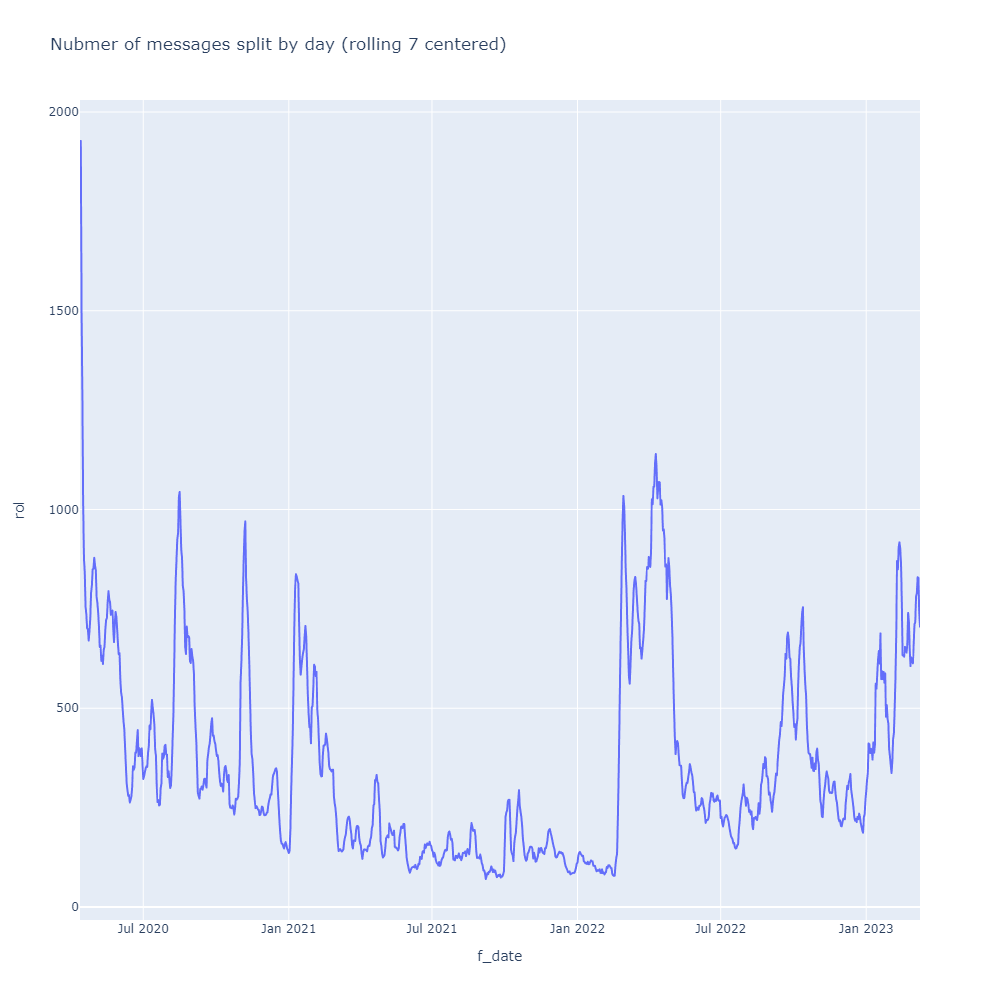

In [32]:
# Кол-во сообщений в день
import pandas as pd; import numpy as np
# Step: Change datetime frequency
df_mes_cnt_day = df.set_index('f_date').resample('1D').size().to_frame(name='cnt').reset_index()
df_mes_cnt_day['rol'] = df_mes_cnt_day['cnt'].rolling(7, center=True).mean().round(2)
import plotly.express as px
fig = px.line(df_mes_cnt_day.sort_values(by=['f_date']\
        , ascending=[True]).dropna(subset=['rol']), x='f_date', y='rol'\
        , title='Nubmer of messages split by day (rolling 7 centered)')
fig

In [33]:
# for i in df_mes_cnt_day.agg(max_=('rol', 'max'), min_=('rol','min'))['rol']:
#     display(df_mes_cnt_day.query('rol == @i'))
# round(df_mes_cnt_day['rol'].mean(), 0)

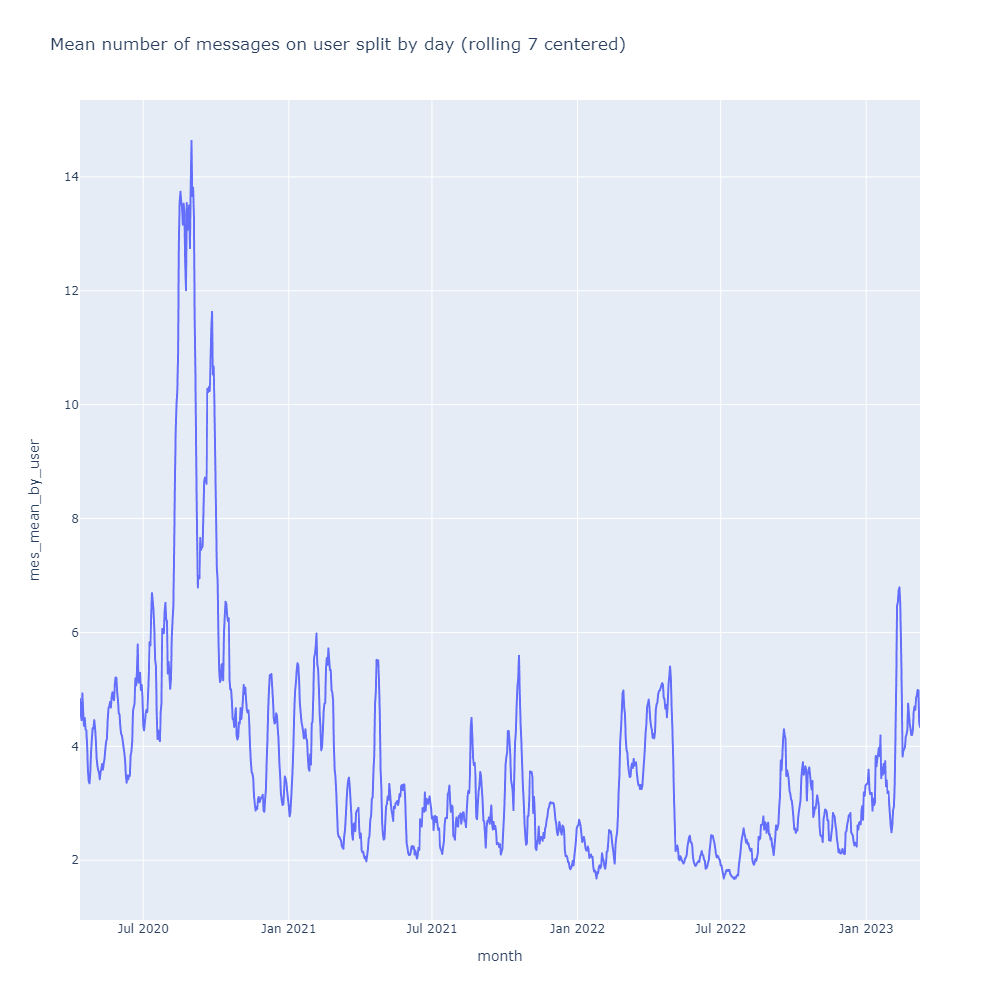

In [34]:
# Среднее кол-во сообщений на пользователя в день
df['day']  = df.f_date.astype('datetime64[D]')
import pandas as pd; import numpy as np
# Step: Group by day and calculate new column(s)
df_mean_mes_by_user_day = df.groupby(['day']).agg(users_cnt=('from_id', 'nunique'), mes_cnt=('from_id', 'size')).reset_index()
df_mean_mes_by_user_day['mes_mean'] = (df_mean_mes_by_user_day.mes_cnt / df_mean_mes_by_user_day.users_cnt)\
    .rolling(7, center=True).mean().round(2)
import plotly.express as px
fig = px.line(df_mean_mes_by_user_day.sort_values(by=['day'], ascending=[True]).dropna(subset=['mes_mean']), x='day', y='mes_mean', title='Mean number of messages on user split by day (rolling 7 centered)')
fig.update_xaxes(title_text='month')
fig.update_yaxes(title_text='mes_mean_by_user')
fig

In [35]:
# for i in df_mean_mes_by_user_day.agg(max_=('mes_mean', 'max'), min_=('mes_mean','min'))['mes_mean']:
#     display(df_mean_mes_by_user_day.query('mes_mean == @i'))
# round(df_mean_mes_by_user_day['mes_mean'].mean(), 0)

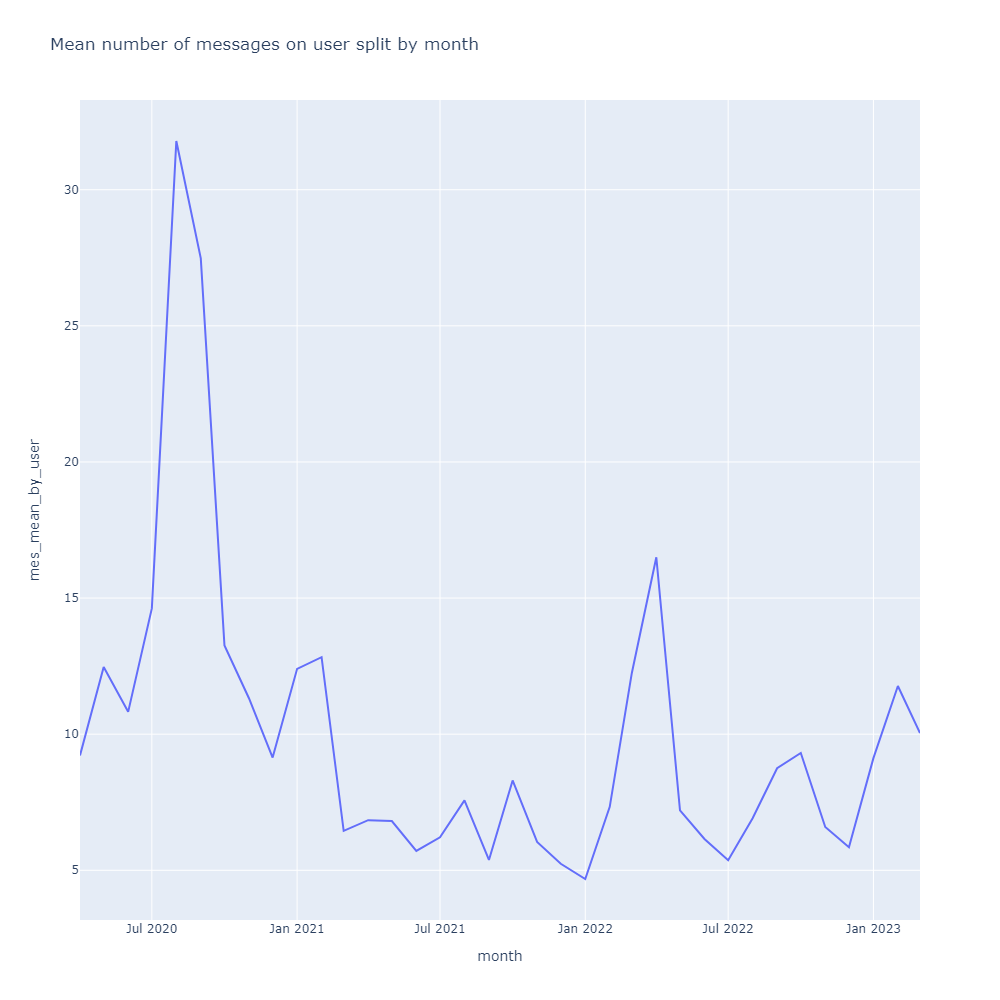

In [36]:
# Среднее кол-во сообщений на пользователя в месяц
df['mo'] = df.f_date.astype('datetime64[M]')
df_mean_mes_by_user_mo = df.groupby(['mo']).agg(users_cnt=('from_id', 'nunique'), mes_cnt=('from_id', 'size')).reset_index()
df_mean_mes_by_user_mo['mes_mean'] = (df_mean_mes_by_user_mo.mes_cnt / df_mean_mes_by_user_mo.users_cnt)\
    .round(2)
import plotly.express as px
fig = px.line(df_mean_mes_by_user_mo.sort_values(by=['mo'], ascending=[True]).dropna(subset=['mes_mean'])\
              , x='mo', y='mes_mean', title='Mean number of messages on user split by month')
fig.update_xaxes(title_text='month')
fig.update_yaxes(title_text='mes_mean_by_user')
fig

In [37]:
# for i in df_mean_mes_by_user_mo.agg(max_=('mes_mean', 'max'), min_=('mes_mean','min'))['mes_mean']:
#     display(df_mean_mes_by_user_mo.query('mes_mean == @i'))
# round(df_mean_mes_by_user_mo['mes_mean'].mean(), 0)

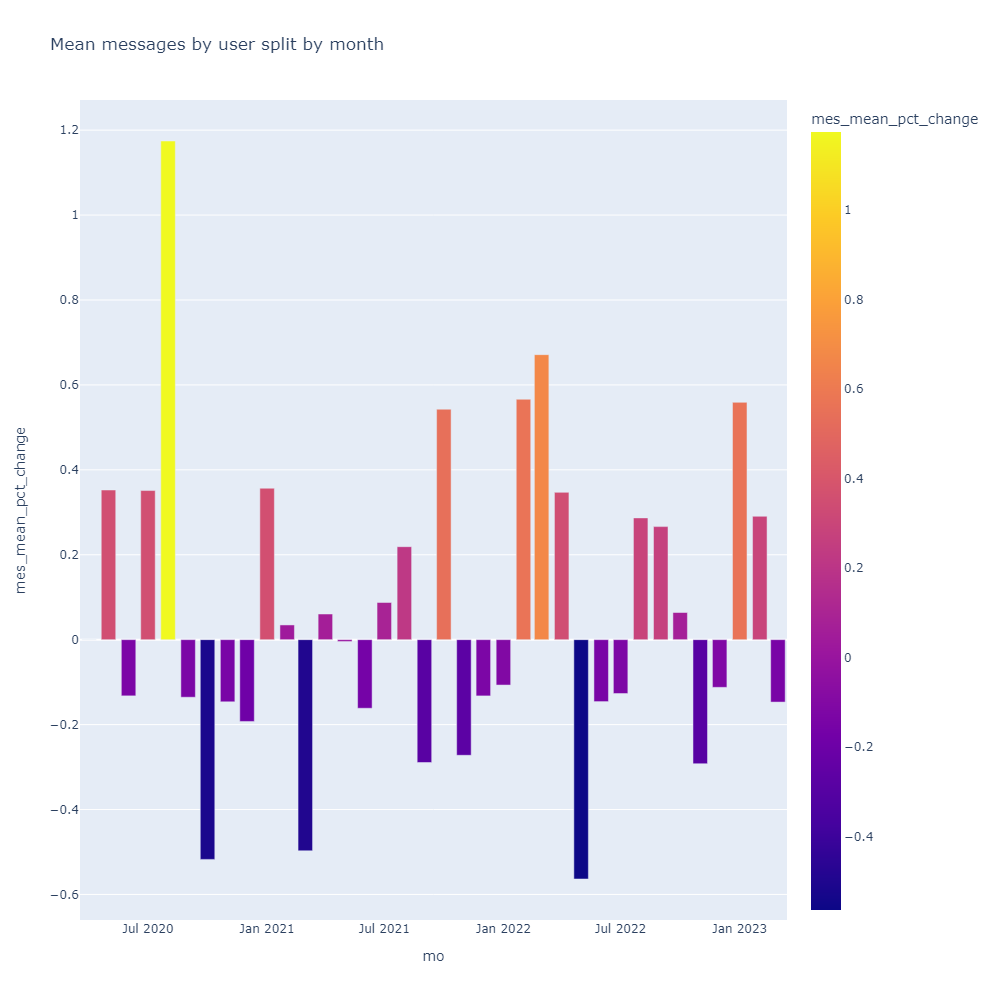

In [38]:
import pandas as pd; import numpy as np
# Step: Percentage change
df_mean_mes_by_user_mo['mes_mean_pct_change'] = df_mean_mes_by_user_mo['mes_mean'].transform('pct_change')

df_mean_mes_by_user_mo = df_mean_mes_by_user_mo.fillna(0)
import plotly.express as px
fig = px.bar(df_mean_mes_by_user_mo, x='mo', y='mes_mean_pct_change', color='mes_mean_pct_change', title='Mean messages by user split by month')
fig

In [39]:
# for i in df_mean_mes_by_user_mo.agg(max_=('mes_mean_pct_change', 'max'), min_=('mes_mean_pct_change','min'))['mes_mean_pct_change']:
#     display(df_mean_mes_by_user_mo.query('mes_mean_pct_change == @i'))
# round(df_mean_mes_by_user_mo['mes_mean_pct_change'].mean(), 0)

### **Вывод**

* Среднее кол-во привлеченных пользователей составляет 377 в месяц, максимальное 2640 (2020-04), минимальное – 110 (2021-09)
Максимальный прирост кол-ва пользователей составляет 152% к предыдущему (2022-03), минимальный - -60% (2023-03). Средний прирост составляет 0% - активность группы стагнирует
Максимальное число активных пользователей – 2640 (2020-04), минимальное – 430 (2020-09), среднее – 1109

* Максимальное число сообщений – 28527 (2022-04), минимальное – 2607 (2021-09-01), среднее – 10884

* Максимальный прирост кол-ва сообщений составляет 222% к предыдущему (2022-03), минимальный - -62% (2022-05). Средний прирост составляет 0% - активность группы стагнирует
Кол-во сообщений в день по скользящему среднему за 7 дней составляет максимальное 1927 (2020-04), минимальное – 57 (2021-09), среднее – 361

* Максимальное кол-во сообщений в день на пользователя по скользящему среднему за 7 дней составляет 15 (2020-08), минимальное 1,67 (2020-08), среднее – 4

* Максимальное кол-во сообщений в месяц на пользователя составляет 31.79 (2020-08), минимальное 4.68 (2022-01), среднее – 10

* Максимальный прирост среднего кол-ва сообщений в месяц на пользователя составляет 117% к предыдущему (2020-08), минимальный - -56% (2022-05). Средний прирост составляет 0% - активность группы стагнирует


## Анализ совместной активности пользователей

Возьмем один месяц для примера

In [40]:
df = pd.read_feather("N:\TG archives\Peach Blossom\peach_blossom.feather")
df['f_mo'] = df.f_date.astype('datetime64[M]')
df_intervals = df.query('f_mo == "2020-09-01"')

# df = df.head(5000)
import pandas as pd; import numpy as np
# Step: Change data type of date to Datetime
df_intervals['f_date'] = pd.to_datetime(df_intervals['f_date'], format='%Y-%m-%d %H:%M:%S')

import pandas as pd; import numpy as np
# Step: Drop columns
df_intervals = df_intervals.drop(columns=['action'])

import pandas as pd; import numpy as np
# Step: Drop missing values in [All columns]
df_intervals = df_intervals.dropna()

df_intervals['from_id'] = df_intervals.from_id.apply(user_id)
import pandas as pd; import numpy as np
# Step: Drop missing values in [All columns]
df_intervals = df_intervals.dropna()


import pandas as pd; import numpy as np
# Step: Change data type of actor_id to Integer
df_intervals['from_id'] = df_intervals['from_id'].astype('Int64')
import pandas as pd; import numpy as np
# Step: Select columns
df_intervals = df_intervals[['f_date', 'from_id']]

# df_intervals

In [41]:
start = time.time()

df_intervals['n'] = 1
freq = 'D'

begin = df_intervals.f_date.min().replace(day=1, hour=0, minute=0, second=0)
end = df_intervals.f_date.max()\
    .replace(day=(monthrange(df_intervals.f_date.max().year, df_intervals.f_date.max().month))[1], hour=0, minute=0, second=0)
df_intervals
df_nbi = pd.DataFrame()   
s= 0
for i in df_intervals.from_id.unique():
    begin_ = pd.DataFrame({'from_id':i,\
                  'f_date':begin}, index=[0])
    end_ = pd.DataFrame({'name':i,\
                  'f_date':end}, index=[0])
    
    
    df_ = pd.concat([pd.concat([df_intervals.loc[df_intervals.from_id == i], begin_], ignore_index=True), end_]\
                    , ignore_index=True)\
        .set_index('f_date').resample(freq).count().reset_index()#\
    df_['from_id'] = i
    df_nbi = pd.concat([df_nbi, df_])
    s += 1
    if s % 500 == 0:
        print(s)
df_nbi = df_nbi.rename(columns=({'n':'cnt'}))

df_pi = pd.pivot_table(df_nbi, columns=['from_id'], index=['f_date'], values='cnt')
dfpc = pd.DataFrame(np.corrcoef(df_pi.values, rowvar=False).round(5))
dfpc.columns, dfpc.index = df_pi.columns, df_pi.columns
dfpc = dfpc.rename_axis(None).rename_axis(None, axis=1)

dfpc
uns = dfpc.unstack().reset_index()
import pandas as pd; import numpy as np
uns.columns = [str(column) for column in uns.columns]

uns = uns.rename(columns={'level_0': 'name1', 'level_1': 'name2', '0': 'corr_c'})

uns = uns.query('name1 != name2')
import pandas as pd; import numpy as np
uns.columns = [str(column) for column in uns.columns]

import pandas as pd; import numpy as np
# Step: Change data type of name1 to String/Text
uns['name1'] = uns['name1'].astype('string')

# Step: Change data type of name2 to String/Text
uns['name2'] = uns['name2'].astype('string')
uns['nn'] = uns.name1 + ',' + uns.name2

def splt(col):
    return sorted(col.split(','))
uns.nn = uns.nn.apply(splt)

import pandas as pd; import numpy as np
# Step: Sort column(s) nn ascending (A-Z)
uns = uns.sort_values(by=['nn'], ascending=[True])

import pandas as pd; import numpy as np
# Step: Drop columns
uns = uns.drop(columns=['name1', 'name2'])

def n1(col):
    return col[0]
def n2(col):
    return col[1]

uns['name1'] = uns.nn.apply(n1)
uns['name2'] = uns.nn.apply(n2)
import pandas as pd; import numpy as np
# Step: Drop columns
uns = uns.drop(columns=['nn'])

uns = uns.drop_duplicates()
uns.corr_c = uns.corr_c.fillna(0)

uns_pos = uns.query('corr_c >= 0')
uns_pos['corr_cat'] = pd.cut(uns_pos.corr_c, np.arange(0, 1.1, 0.2)).cat.codes + 1
uns_neg = uns.query('corr_c < 0')
uns_neg['corr_cat'] = (pd.cut(uns_neg.corr_c*(-1), np.arange(0, 1.1, 0.2)).cat.codes + 1) * (-1)
uns_res = pd.concat([uns_neg, uns_pos], ignore_index=True)
import pandas as pd; import numpy as np
# Step: Sort column(s) corr_c ascending (A-Z)
uns_res = uns_res.sort_values(by=['name1'], ascending=[True])


print(time.time() - start)
# uns_res


3.944847583770752


In [42]:
def interval_corr_groups(freq):
    import pandas as pd; import numpy as np
    start = time.time()

    df_intervals['n'] = 1
#     freq = 'D'

    begin = df_intervals.f_date.min().replace(day=1, hour=0, minute=0, second=0)
    end = df_intervals.f_date.max()\
        .replace(day=(monthrange(df_intervals.f_date.max().year, df_intervals.f_date.max().month))[1]\
                 , hour=0, minute=0, second=0)
    df_intervals
    df_nbi = pd.DataFrame()   
    s= 0
    for i in df_intervals.from_id.unique():
        begin_ = pd.DataFrame({'from_id':i,\
                      'f_date':begin}, index=[0])
        end_ = pd.DataFrame({'name':i,\
                      'f_date':end}, index=[0])


        df_ = pd.concat([pd.concat([df_intervals.loc[df_intervals.from_id == i], begin_], ignore_index=True), end_]\
                        , ignore_index=True)\
            .set_index('f_date').resample(freq).count().reset_index()#\
        df_['from_id'] = i
        df_nbi = pd.concat([df_nbi, df_])
#         s += 1
#         if s % 50 == 0:
#             print(s)
    df_nbi = df_nbi.rename(columns=({'n':'cnt'}))

    df_pi = pd.pivot_table(df_nbi, columns=['from_id'], index=['f_date'], values='cnt')
    dfpc = pd.DataFrame(np.corrcoef(df_pi.values, rowvar=False).round(5))
    dfpc.columns, dfpc.index = df_pi.columns, df_pi.columns
    dfpc = dfpc.rename_axis(None).rename_axis(None, axis=1)

    dfpc
    uns = dfpc.unstack().reset_index()
    import pandas as pd; import numpy as np
    uns.columns = [str(column) for column in uns.columns]

    uns = uns.rename(columns={'level_0': 'name1', 'level_1': 'name2', '0': 'corr_c'})

    uns = uns.query('name1 != name2')
    import pandas as pd; import numpy as np
    uns.columns = [str(column) for column in uns.columns]

    import pandas as pd; import numpy as np
    # Step: Change data type of name1 to String/Text
    uns['name1'] = uns['name1'].astype('string')

    # Step: Change data type of name2 to String/Text
    uns['name2'] = uns['name2'].astype('string')
    uns['nn'] = uns.name1 + ',' + uns.name2

    def splt(col):
        return sorted(col.split(','))
    uns.nn = uns.nn.apply(splt)

    import pandas as pd; import numpy as np
    # Step: Sort column(s) nn ascending (A-Z)
    uns = uns.sort_values(by=['nn'], ascending=[True])

    import pandas as pd; import numpy as np
    # Step: Drop columns
    uns = uns.drop(columns=['name1', 'name2'])

    def n1(col):
        return col[0]
    def n2(col):
        return col[1]

    uns['name1'] = uns.nn.apply(n1)
    uns['name2'] = uns.nn.apply(n2)
    import pandas as pd; import numpy as np
    # Step: Drop columns
    uns = uns.drop(columns=['nn'])

    uns = uns.drop_duplicates()
    uns.corr_c = uns.corr_c.fillna(0)

    uns_pos = uns.query('corr_c >= 0')
    uns_pos['corr_cat'] = pd.cut(uns_pos.corr_c, np.arange(0, 1.1, 0.2)).cat.codes + 1
    uns_neg = uns.query('corr_c < 0')
    uns_neg['corr_cat'] = (pd.cut(uns_neg.corr_c*(-1), np.arange(0, 1.1, 0.2)).cat.codes + 1) * (-1)
    uns_res = pd.concat([uns_neg, uns_pos], ignore_index=True)
    import pandas as pd; import numpy as np
    # Step: Sort column(s) corr_c ascending (A-Z)
    uns_res = uns_res.sort_values(by=['name1'], ascending=[True])


    uns_groups = uns_res.groupby('corr_cat', as_index=False).name1.count().rename(columns={'name1': 'cnt'})

    uns_groups['freq'] = freq
    uns_groups['share'] = (uns_groups.cnt / uns_groups.cnt.sum())#.round(2)

#     print(time.time() - start)

    return uns_groups, uns_res


In [43]:
# intervals = []
# for i in range(1, 86401, 1440):
#     intervals.append(str(i) + 'T')
intervals = ['1T', '2T', '5T', '10T', '15T', '30T', '1h', '2h', '4h', '8h', '12h',\
             'D', '2D', '5D', '10D', '15D', '20D', '25D', '29D']
# intervals = ['10D', '15D']
df_i = pd.DataFrame()
for i in intervals:
    start = time.time()
    df_ = interval_corr_groups(i)[0]
    df_['freq'] = i
    df_i = pd.concat([df_i, df_], ignore_index= True)
#     if int(i[:-1]) % 100 == 1:
    print(f'{i} took {round(time.time() - start, 2)} seconds')

1T took 75.39 seconds
2T took 39.74 seconds
5T took 19.53 seconds
10T took 12.55 seconds
15T took 9.5 seconds
30T took 6.7 seconds
1h took 7.03 seconds
2h took 6.04 seconds
4h took 4.91 seconds
8h took 4.59 seconds
12h took 4.0 seconds
D took 4.49 seconds
2D took 4.44 seconds
5D took 4.85 seconds
10D took 4.44 seconds
15D took 4.73 seconds
20D took 4.86 seconds
25D took 4.46 seconds
29D took 4.63 seconds


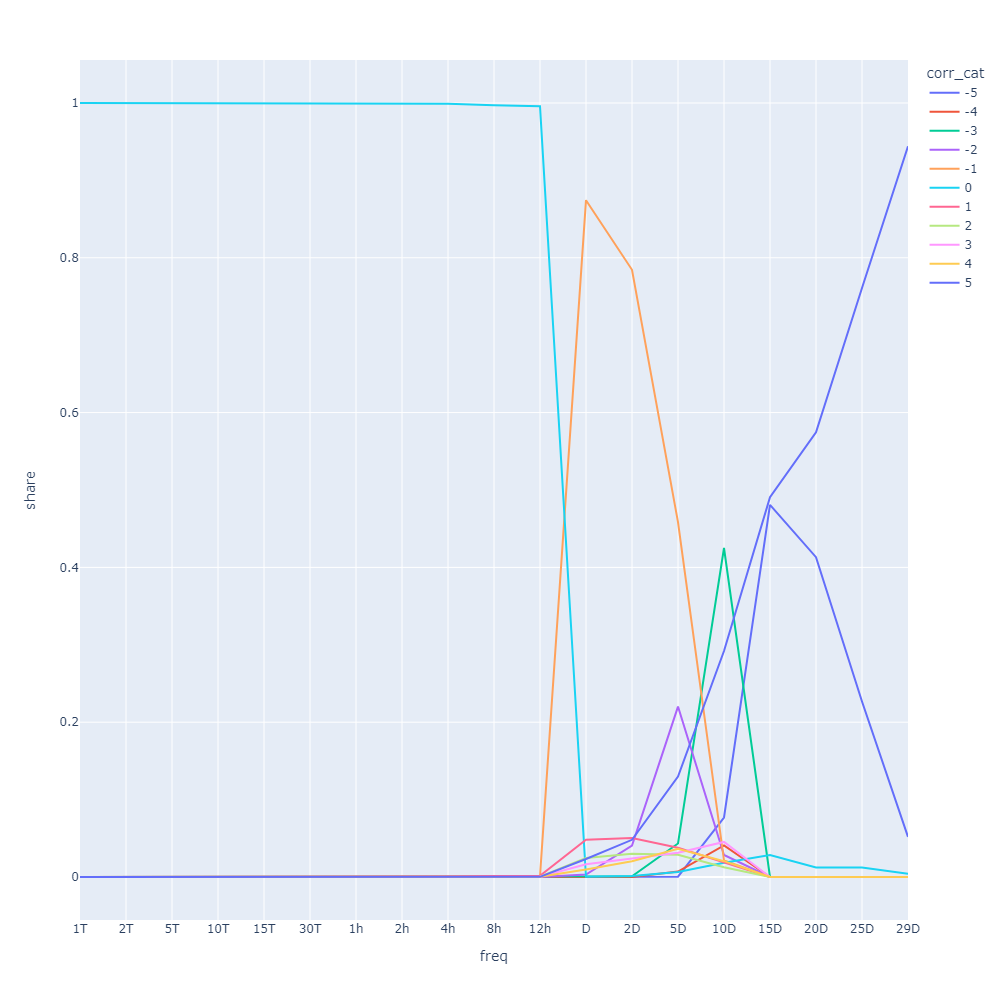

In [44]:
df_i
df_i_ = pd.DataFrame({'corr_cat':[-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]})
df_ = pd.DataFrame()
for i in df_i.freq.unique():
    sl = df_i.query('freq == @i').merge(df_i_, on='corr_cat', how='right')
    sl.freq = i
    sl = sl.fillna(0)
    df_ = pd.concat([df_, sl], ignore_index=True)
df_i = df_
import plotly.express as px
fig = px.line(df_, x='freq', y='share', color='corr_cat')
fig

In [45]:
def corr_quant_share(freq):
    import pandas as pd; import numpy as np
    res = interval_corr_groups(freq)[1]
    corr_quant_share_ = []
    for i in range(-5, 6):
         corr_quant_share_.append(len(set(list(res.loc[res.corr_cat == i].name1) + list(res.loc[res.corr_cat == i].name2))))
    corr_quant_share_ = pd.DataFrame(corr_quant_share_)
    import pandas as pd; import numpy as np
    corr_quant_share_.columns = [str(column) for column in corr_quant_share_.columns]
    # Step: Rename column
    corr_quant_share_ = corr_quant_share_.rename(columns={'0': 'cnt'})
    corr_quant_share_['corr_cat'] = list(range(-5, 6))
    corr_quant_share_['share'] = round(corr_quant_share_.cnt / df.query('f_mo == "2020-09-01"').from_id.nunique(), 8)
    corr_quant_share_['freq'] = freq
    return corr_quant_share_

1T took 82.1 seconds
2T took 40.82 seconds
5T took 18.43 seconds
10T took 11.53 seconds
15T took 9.19 seconds
30T took 6.5 seconds
1h took 5.46 seconds
2h took 4.57 seconds
4h took 4.4 seconds
8h took 4.07 seconds
12h took 4.32 seconds
D took 4.43 seconds
2D took 4.1 seconds
5D took 4.93 seconds
10D took 4.23 seconds
15D took 4.27 seconds
20D took 4.18 seconds
25D took 4.48 seconds
29D took 4.2 seconds


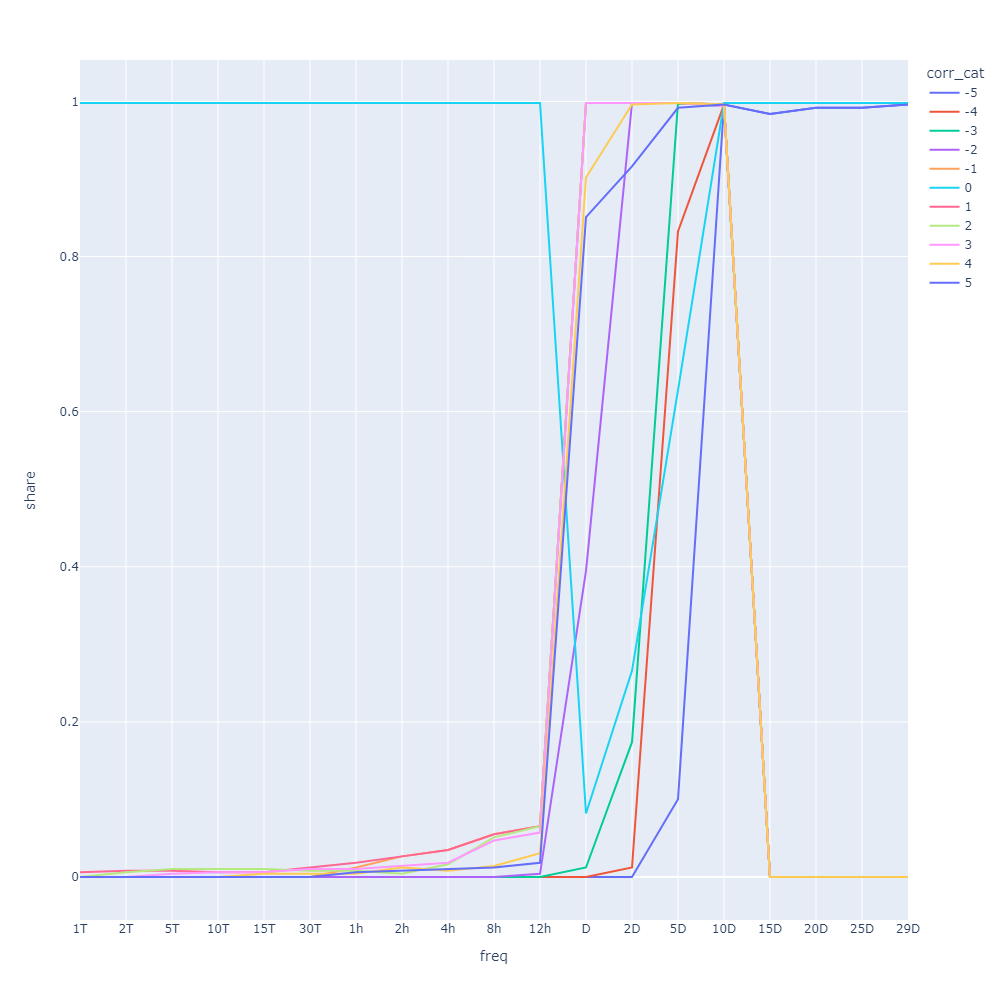

In [46]:
# intervals = []
# for i in range(1,81, 1):
#     intervals.append(str(i) + 'D')
intervals = ['1T', '2T', '5T', '10T', '15T', '30T', '1h', '2h', '4h', '8h', '12h', 'D', '2D', '5D', '10D', '15D',\
             '20D', '25D', '29D']
df_ = pd.DataFrame()
for i in intervals:
    start = time.time()
    df_ = pd.concat([df_, corr_quant_share(i)])
#     if int(i[:-1]) % 10 == 0:
        
    print(f'{i} took {round(time.time() - start, 2)} seconds')
df_

import plotly.express as px
fig = px.line(df_, x='freq', y='share', color='corr_cat')
fig

### **Вывод**

* Крайние корреляционные парные категории (-5 и 5) пересекаются в районе 15 дня и расходятся за месячным пределом анализа, что говорит о том, что активность всех пользователей распределена далее месячного отрезка анализа и вовлечение всех пользователей происходит далее предела в 30 дней.

* По количеству вовлеченность почти всех пользователей, показавших какую-либо активность, происходит на 2-й день (99,18%), далее на 5-й день растет обратная корреляция также почти до предела в 1 (99,6%), что говорит о том, что к 5-му дню происходит дробление пользователей на группы, находящиеся в противофазе подневной активности.


## **Общий вывод**

***`Когортный анализ`***


* Архив содержит 537,318 записей о совершенных действиях
* Кол-во приглашенных за отчетный период – 32,494
* Кол-во когорт – 31
* Период анализа – 6 месяцев
* Средний уровень удержания на второй месяц оставляет 31,6%
* Все когорты имеют тенденцию снижения на второй месяц, некоторые - с небольшими всплесками уровня удержания порядка 2-5% в последующие месяцы
* Лучшая когорта с удержанием 52% на второй месяц стартовала в феврале 2022, худшая – с удержанием 16% - в августе 2020 года
* Имеются несколько когорт, наращивающие свое присутствие после второго месяца. Это: 2020-08, 2020-07, 2021-08, 2021-10, 2021-11, 2021-12, 2022-05, 2022-09, 2022-10
* Кумулятивный пик кол-ва сообщений когорт находится в сентябре 2020 и составляет порядка 102,000


***`Количественный анализ`***


* Среднее кол-во привлеченных пользователей составляет 377 в месяц, максимальное 2640 (2020-04), минимальное – 110 (2021-09)
Максимальный прирост кол-ва пользователей составляет 152% к предыдущему (2022-03), минимальный - -60% (2023-03). Средний прирост составляет 0% - активность группы стагнирует
Максимальное число активных пользователей – 2640 (2020-04), минимальное – 430 (2020-09), среднее – 1109

* Максимальное число сообщений – 28527 (2022-04), минимальное – 2607 (2021-09-01), среднее – 10884

* Максимальный прирост кол-ва сообщений составляет 222% к предыдущему (2022-03), минимальный - -62% (2022-05). Средний прирост составляет 0% - активность группы стагнирует
Кол-во сообщений в день по скользящему среднему за 7 дней составляет максимальное 1927 (2020-04), минимальное – 57 (2021-09), среднее – 361

* Максимальное кол-во сообщений в день на пользователя по скользящему среднему за 7 дней составляет 15 (2020-08), минимальное 1,67 (2020-08), среднее – 4

* Максимальное кол-во сообщений в месяц на пользователя составляет 31.79 (2020-08), минимальное 4.68 (2022-01), среднее – 10

* Максимальный прирост среднего кол-ва сообщений в месяц на пользователя составляет 117% к предыдущему (2020-08), минимальный - -56% (2022-05). Средний прирост составляет 0% - активность группы стагнирует


***`Анализ совместной активности пользователей`***




* Крайние корреляционные парные взаимодействия пользователей (-5 и 5) пересекаются в районе 15 дня и расходятся за месячным пределом анализа, что говорит о том, что активность всех пользователей распределена далее месячного отрезка анализа и вовлечение всех пользователей происходит далее предела в 30 дней.

* По количеству вовлеченность почти всех пользователей, показавших какую-либо активность, происходит на 2-й день (99,18%), далее на 5-й день растет обратная корреляция также почти до предела в 1 (99,6%), что говорит о том, что к 5-му дню происходит дробление пользователей на группы, находящиеся в противофазе подневной активности.


***Примечание***

*данный анализ не имеет рекомендаций, так как проведен в целях общего изучения предмета и тренировки аналитических навыков*